# Self-Attention GANの概要
Goodfellowらによる2018版GAN  
現在StateOfTheArtのBigGANのベースにもなっている  
  
SAGANは次の技術要素を用いているのでまずは解説する
- Self-Attention
- pointwise convolution
- Spectral Normalization

## 従来のGANの問題点
通常のGANのGeneratorでは転置畳み込みを用いる  
しかし転置畳み込みは局所的な情報の拡大にしかならないという問題がある

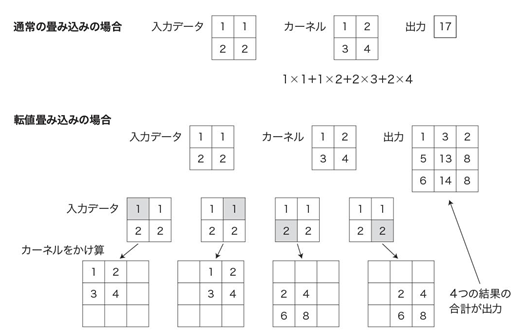
カーネルサイズを大きくするという手もあるが，それは計算コストが大きすぎる  

## Self-Attentionの導入
拡大する際に画像全体の大域的な情報を考慮したい  
そのために，「あるセルを生成するとき，注目すべきセルは自分自身と値が似ているセル」という考え方を導入するのがSA  
これにより，実質画像全体分のカーネルのような考慮ができるが，カーネルの値を毎回学習させるのではなく，自身との似ている度合いをカーネル値として計算することで，計算量の削減ができる
  
前節で用いたのCNNレイヤは4つあった．  
それらレイヤ間の出力を$x$(C, W, H)とする．  
これらの$x$に大域的情報$\gamma o$を追加し，
$$ y = x + \gamma o$$
を次の層に入力することでこれを実現する  
$\gamma$は適当な係数，$o$は大域的な情報を用いて調整を行うSelf-Attention Mapと呼ばれるもの  
($\gamma$も学習パラメータ)

この$o$を作成するための一つの方法に，全結合層を使う方法がある  
しかし全結合層だと計算コストが高く，線形和しか作成できないので表現力も乏しい  
そこでまず$x$を(C,W,H)から(C,N)に変形し，行列演算しやすくする  
ここで，N=WHであり，ただ2次元画像を1次元に直しただけである  
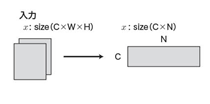

この変形した$x$同士の掛け算
$$ S = x^\top x $$
を得る．  
この(N,N)行列の要素$S_{ij}$は画像位置$i$が画像位置$j$とどれくらい似ているかを示す  
画像位置は今N個あるが，それぞれ同じ位置同士でチャネルごとに掛け算した和になる  
値が似ていると$S_{ij}$は大きくなるのでこれは画像位置$i$と$j$の似ている度を意味する  
(類似度ではなく，両方明るければ大きくなる，ってだけでは？ピクセルの情報がone-hotだったり，2色化されているなら類似度と言ってもいいけど…)  
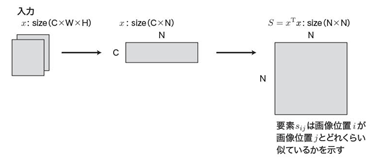

続いて$S$を規格化する  
行方向にソフトマックス関数を計算し$i$行の画像位置に対する$j$列の似ている度の総和を1にする  
さらにそれを転置する  
このソフトマックス関数の計算は  
$$ \beta_{j,i} = \frac{\exp(s_{ij})}{\sum_{i=1}^N \exp(s_{ij})} $$
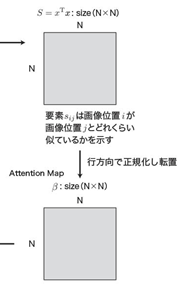
(転置操作のため$i,j$がひっくり返る)  
この$\beta$をAttention Mapと呼ぶ  
$\beta$の各要素は，「位置$j$を生成する際に位置$i$をどの程度考慮すべきか」を示す．

最後に，(C, N)の行列$x$と$\beta$を掛け算することで，$x$に対応する$o$が得られる  
$$ o = x\beta^\top $$
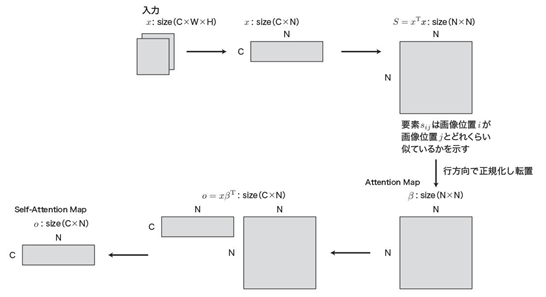

しかし，「自分自身と値が似ているセルに着目」という制限は強いので，一度$x$を特徴量変換してからSelf-Attentionに与える．

## 1×1 Convolutions (pointwise convolution)
$x$の特徴量変換の手法として，カーネルサイズ1の畳み込み層で(C, W, H)を(C', W, H)に変換  
要はチャネルの線形結合みたいなもの  
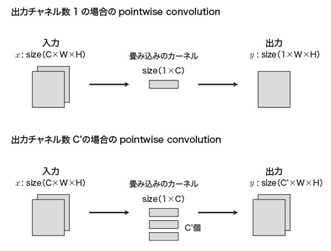  
これは主成分分析のような次元圧縮にあたり，計算コストを抑える効果もある．  
$x$の情報が欠落しにくい線形和の係数を逆伝搬で学習する．  

## Spectral Normalization
Batch Normはモデル内のデータに対する規格化だが，こちらは重みを規格化する．  
  
まず，GANがうまく機能するには，Dが「リプシッツ連続性」を有する必要がある  
これは，「Dへの入力画像が少し変化してもDの出力はほとんど変化しない」という意味  
層の重みの最大固有値で重みを割ることで規格化する．  
これにより，画像A，Bにほんの少し違う部分があったとき，そこが過剰に拡大されなくなる  
  
詳しいことは文献5, 6を参照  
SAGANでは，DとGの両方にSpectral Normalizationを適用する．  
  
実装にはnn.utils.spectral_normを使う

# Self-Attention GANの学習，生成の実装
Self-Attentionによる可視化も後で行う

In [1]:
import os
from sklearn.datasets import fetch_openml
from PIL import Image
import numpy as np

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import models, transforms
from IPython.display import clear_output
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "../../datasets/ptca_datasets/chapter5"
img_78_path = os.path.join(data_dir, "img_78")

In [3]:
class SelfAttention(nn.Module):
    """ Self Attention Layer """
    
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        
        # Self Attention の学習に使用する層を定義
        
        # pointwise convolutionによる特徴量変換，圧縮
        # Attention Mapに使われるxは3つあり，それぞれに対して適用
        # これが非常に大きなカーネルを設定するよりも高速になるらしい
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, 
            out_channels=in_dim//8,
            kernel_size=1
        )
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, 
            out_channels=in_dim//8,
            kernel_size=1
        )
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, 
            out_channels=in_dim,
            kernel_size=1
        )
        
        # Attention Map 作成時の規格化用Softmax
        self.softmax = nn.Softmax(dim=-2)
        
        # Attention Mapにかける係数
        self.gamma = nn.Parameter(torch.zeros(1))
        
        
    def forward(self, x):
        
        # (B, C', W, H) -> (B, C', N)
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        
        # 転置 x^t
        proj_query = proj_query.permute(0, 2, 1)
        
        # 転置してない方の x
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2] * x.shape[3]) # (B, C', N)
        
        # バッチごとに行列の掛け算 x^t x を行う
        S = torch.bmm(proj_query, proj_key)
        
        # 規格化と転置を行い，Attention Mapを作成
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)
        
        # xに対応する調整量 o を取得
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]) # (B, C', N)
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        
        # x + gamma o　を返す
        o = o.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        out = x + self.gamma * o
        
        return out, attention_map

## Generatorの実装
基本的にはDCGANだが，いくつか変更点がある  
- 転置畳み込み層にSpectral Normalizationを適用(last以外)
- layer3,4の間，layer4,lastの間にSelf-Attentionを適用

可視化用のAttention Mapも出力

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            # Spectral Normalizationを適用
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1)
            ),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            # Spectral Normalizationを適用
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1)
            ),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            # Spectral Normalizationを適用
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1)
            ),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        # Self-Attention Layer 1
        self.self_attention1 = SelfAttention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを適用
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1)
            ),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        # Self-Attention Layer 2
        self.self_attention2 = SelfAttention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

## Discriminatorの実装
Generatorと同様，Spectral NormとSelf-Attentionを追加

In [5]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)
            ),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)
            ),   
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)
            ),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        # Self Attention Layer 1
        self.self_attention1 = SelfAttention(in_dim=image_size*4)
        
        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)
            ),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        # Self Attention Layer 2
        self.self_attention2 = SelfAttention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

## DataLoaderの作成
DCGANの時と同じ

In [6]:
def make_datapath_list():
    """
    学習，検証の画像データとアノテーションデータへのファイルパスリストを作成
    """
    
    train_img_list = []
    
    for img_idx in range(200):
        img_path=os.path.join(img_78_path, f"img_7_{img_idx}.jpg")
        train_img_list.append(img_path)
        
        img_path=os.path.join(img_78_path, f"img_8_{img_idx}.jpg")
        train_img_list.append(img_path)
    
    return train_img_list

In [7]:
class ImageTransform():
    """
    画像の前処理クラス
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        return img_transformed

DataLoaderの作成と動作確認

In [8]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size()) # (M, C, H, W)

torch.Size([64, 1, 64, 64])


## ネットワークの初期化と学習の実施
SAGANの損失関数は，hinge version of the adversarial lossと呼ばれるものになる  
Dの損失関数(logがなくなり，ReLUになっている)  
$$ -\frac{1}{M} \sum_{i=1}^{M} [ l_i * \min(0, -1 + y_i) + (1 - l_i) * \min(0, -1 - y_i) ] $$
Gの損失関数(logがなくなり，バッチ数で割っている)  
$$ - \frac{1}{M} \sum_{i=1}^M D(G(z_i)) $$
  
経験的にうまく学習できるらしい．  
経験的にうまくいくという理由から使用されるケースが多い

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

print(G, "\n", D)

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (self_attention1): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-2)
  )
  (layer4): Sequential(
    (0): 

学習の関数を実装  
損失関数意外はDCGANとほぼ同じ

In [11]:
def get_device(benchmark=True):
    # GPUが使用可能ならば設定
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス: ", device)
    
    # ネットワークがある程度固定であれば，高速化できる
    torch.backends.cudnn.benchmark = benchmark
    
    return device

In [12]:
def train_model(G, D, dataloader, num_epochs, device=None):
    
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    z_dim = 20
    
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    if device:
        G.to(device)
        D.to(device)
    G.train()
    D.train()
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        clear_output()
        print("-----------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-----------------")
        print(' (train) ')
        
        for images in dataloader:
            
            mini_batch_size = images.size()[0]
            if mini_batch_size == 1:
                continue
            
            
            #################
            # データの作成
            #################
            label_real = torch.full((mini_batch_size,), 1)
            label_fake = torch.full((mini_batch_size,), 0)
            input_d_z = torch.randn(mini_batch_size, z_dim)
            input_d_z = input_d_z.view(input_d_z.size(0), input_d_z.size(1), 1, 1)
            input_g_z = torch.randn(mini_batch_size, z_dim)
            input_g_z = input_g_z.view(input_g_z.size(0), input_g_z.size(1), 1, 1)

            if device:
                images = images.to(device)
                label_real = label_real.to(device)
                label_fake = label_fake.to(device)
                input_d_z = input_d_z.to(device)
                input_g_z = input_g_z.to(device)

            
            #################
            # Discriminator
            #################
            
            # Self-Attentionを利用したDを使用
            d_out_real, _, _ = D(images)
            fake_images, _, _ = G(input_d_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差を計算 (hinge version of the adversarial loss)
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            d_loss = d_loss_real + d_loss_fake
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            
            #################
            # Generator
            #################
            
            # Self-Attentionを利用したGを使用
            fake_images, _, _ = G(input_g_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差を計算 (hinge version of the adversarial loss)
            g_loss = - d_out_fake.mean()
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            
            #################
            # 記録
            #################
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        
        
        print("-----------------")
        
        d_loss = epoch_d_loss / batch_size
        g_loss = epoch_g_loss / batch_size
        print(f"epoch {epoch+1} | D loss: {d_loss} | G loss: {g_loss}")
        
        t_epoch_finish = time.time()
        print(f"timer: {t_epoch_finish - t_epoch_start}")
        t_epoch_start = time.time()
    
    return G, D

学習を開始

In [13]:
device = get_device()
G_update, D_update = train_model(
    G=G,
    D=D,
    dataloader=train_dataloader,
    num_epochs=300,
    device=device
)

-----------------
Epoch 300/300
-----------------
 (train) 
-----------------
epoch 300 | D loss: 0.014093648991547525 | G loss: 0.2116007599979639
timer: 0.7983205318450928


画像生成で動作確認

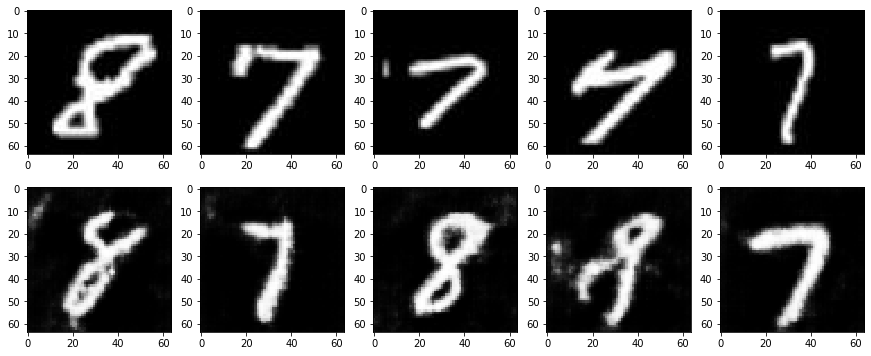

In [21]:
# 生成データ
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 本物データ
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

# 表示
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段は訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段は生成データ
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

生成画像のAttention Mapも可視化

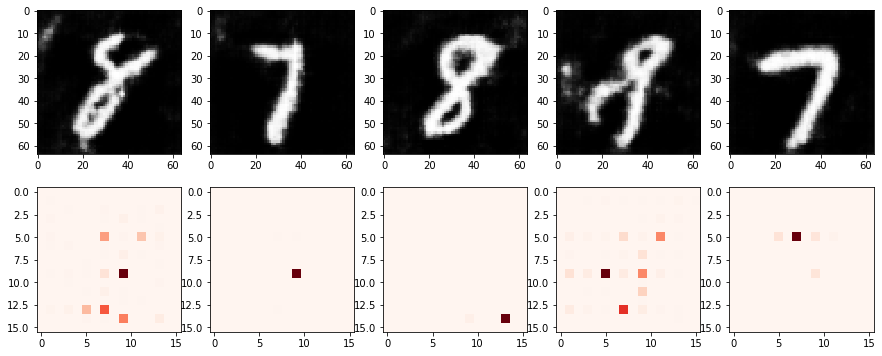

In [25]:
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段は生成データ
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段はAttention Map1
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7] # (16,16)あるMAPの中央に位置するピクセルを見てみる
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

Attention Mapは，各ピクセルがほかのどの特徴量から影響を受けているかを意味する  
例えば左の8を生成した画像は8の形に似たAttentionMapが描かれており，それらの位置のピクセルに似せるようにしてピクセル値を生成しようとしていることになる．